In [1]:
!pip install transformers huggingface_hub tensorflow opencv-python pywavelets

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
from huggingface_hub import from_pretrained_keras
import pywt
import pywt.data
import cv2


In [3]:
image_filename = 'download.png'  # Replace with the actual filename you uploaded
orig = Image.open(image_filename)

In [4]:
model = from_pretrained_keras("keras-io/low-light-image-enhancement")

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
def inference(o_image):
    """
    Process the image through the model and enhance it.
    """
    # Preprocess for the model
    image = keras.preprocessing.image.img_to_array(o_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)  # Create batch of 1 image
    output_image = model(image)  # Run the image through the model
    output_image = post_process(image, output_image)  # Post-process
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)  # Convert back to image
    return Image.fromarray(output_image.numpy())


In [6]:
def post_process(image, output):
    """
    Post-process the output from the model to enhance the image.
    """
    r1 = output[:, :, :, :3]
    r2 = output[:, :, :, 3:6]
    r3 = output[:, :, :, 6:9]
    r4 = output[:, :, :, 9:12]
    r5 = output[:, :, :, 12:15]
    r6 = output[:, :, :, 15:18]
    r7 = output[:, :, :, 18:21]
    r8 = output[:, :, :, 21:24]
    x = image + r1 * (tf.square(image) - image)
    x = x + r2 * (tf.square(x) - x)
    enhanced_img = x + r4 * (tf.square(x) - x)
    x = enhanced_img + r5 * (tf.square(enhanced_img) - enhanced_img)
    x = x + r6 * (tf.square(x) - x)
    x = x + r7 * (tf.square(x) - x)
    enhanced_img = x + r8 * (tf.square(x) - x)
    return enhanced_img

In [7]:
def denoise_image_with_wavelets(image):
    """
    Denoise the image using PyWavelets.
    """
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Convert to grayscale if the image is color
    if image.ndim == 3:
        image = np.mean(image, axis=2)

    # Perform wavelet transform
    coeffs = pywt.wavedec2(image, 'db1', level=2)

    # Unpack the coefficients
    cA2 = coeffs[0]
    cH2, cV2, cD2 = coeffs[1]

    # Threshold the coefficients
    threshold = 0.2 * np.max(cA2)
    cH2 = pywt.threshold(cH2, threshold, mode='soft')
    cV2 = pywt.threshold(cV2, threshold, mode='soft')
    cD2 = pywt.threshold(cD2, threshold, mode='soft')

    # Reconstruct the image
    coeffs = [cA2, (cH2, cV2, cD2)]
    denoised_image = pywt.waverec2(coeffs, 'db1')

    # Clip values to valid range and convert to uint8
    denoised_image = np.clip(denoised_image, 0, 255).astype(np.uint8)

    return Image.fromarray(denoised_image)

def calculate_snr(image):
    """
    Calculate Signal-to-Noise Ratio (SNR) of the given image.
    """
    if isinstance(image, Image.Image):
        image = np.array(image)
    if image.ndim == 3:
        image = np.mean(image, axis=2)  # Convert to grayscale if color image
    mean = np.mean(image)
    variance = np.var(image)
    snr = mean / np.sqrt(variance)
    return snr

In [8]:
def calculate_snr(image):
    """
    Calculate Signal-to-Noise Ratio (SNR) of the given image.
    """
    if isinstance(image, Image.Image):
        image = np.array(image)
    if image.ndim == 3:
        image = np.mean(image, axis=2)  # Convert to grayscale if color image
    mean = np.mean(image)
    variance = np.var(image)
    snr = mean / np.sqrt(variance)
    return snr



In [9]:
orig = Image.open(image_filename)
orig.show(title='Original Image')

# Perform inference to get the enhanced image
enhanced = inference(orig)
enhanced.show(title='Enhanced Image')

# Denoise the enhanced image using PyWavelets
enhanced_denoised = denoise_image_with_wavelets(enhanced)

# Display denoised image
enhanced_denoised.show(title='Enhanced & Denoised Image')

# Calculate SNR for both images
snr_orig = calculate_snr(orig)
snr_enhanced_denoised = calculate_snr(enhanced_denoised)

# Print SNR values
print(f"SNR of Original Image: {snr_orig:.2f}")
print(f"SNR of Enhanced & Denoised Image: {snr_enhanced_denoised:.2f}")

2024-10-19 06:21:53.927537: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41795712 exceeds 10% of free system memory.
2024-10-19 06:21:54.500126: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41795712 exceeds 10% of free system memory.
2024-10-19 06:21:54.576868: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41795712 exceeds 10% of free system memory.
2024-10-19 06:21:54.771026: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41795712 exceeds 10% of free system memory.
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
2024-10-19 06:21:55.243707: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41795712 exceeds 10% of free system memory.
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/t

SNR of Original Image: 1.74
SNR of Enhanced & Denoised Image: 3.03


/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpu11co7ki.PNG'
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmp5wt47zug.PNG'


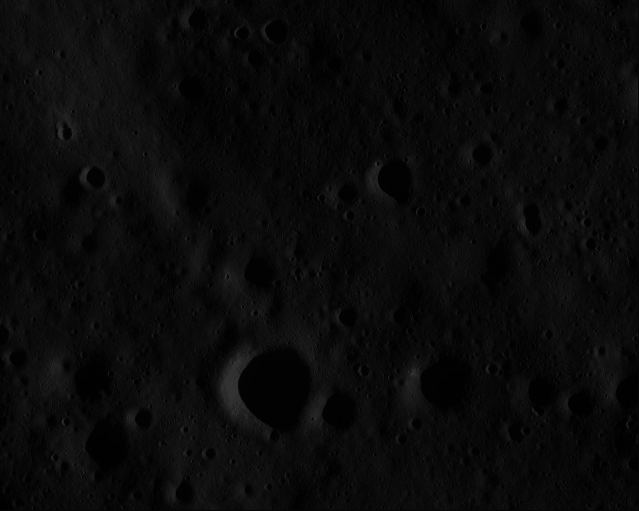

In [10]:
orig = Image.open(image_filename)
orig

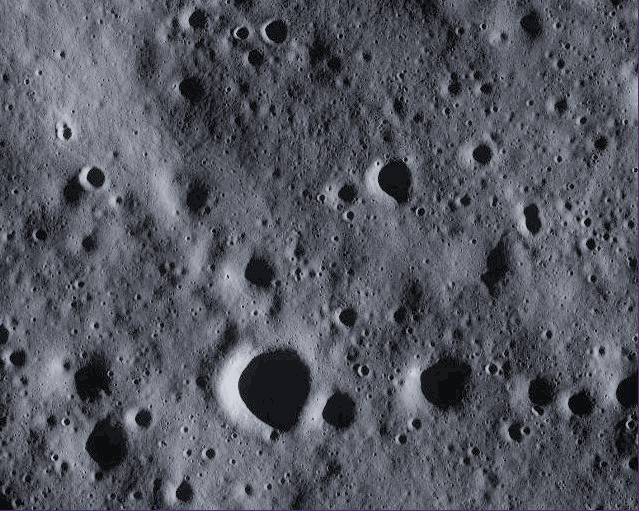

In [11]:
enhanced = inference(orig)
enhanced